![](https://drive.google.com/uc?export=view&id=1AFwhUb9nDTvKm4D6UtSE1Dtjv20THqLX)

<h1><b>Santander Product Recommendation</b></h1>
<h2><i>Can you pair products with people?</i></h2>

#<h2><b> 11. Feature Engineering </b></h2>


##<h3><b> 11.1 Exploring Target Features To Create New Features </b></h3>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import math
import os
from google.colab import drive
import matplotlib.patches as mpatches
import gc

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/21_My_Case_Study_1/')

Mounted at /content/drive


In [2]:
train_vec = pd.read_pickle('train_vec.pkl')
test_vec = pd.read_pickle('test_vec.pkl')

In [3]:
features = ['Date', 'CustomerID', 'Employee', 'Cust_Country', 'Sex', 'Age', 'New','Seniority', 
            'PrimaryCustomer', 'CustomerType', 'CustomerRelationType','SameResidenceCountry', 
            'OtherBirthCountry', 'EntryChannel','ProvinceCode', 'GrossIncome', 'Segment', 'Deceased', 'Active']

cat_feat = ['Employee', 'Cust_Country', 'Sex','New','PrimaryCustomer','CustomerType','CustomerRelationType',
            'SameResidenceCountry','OtherBirthCountry','EntryChannel', 'ProvinceCode','ProvinceName','Segment',
            'Deceased','Active']
            
numerical_feat = ['Age','Seniority','GrossIncome']


product_feat = ['CurrentAccounts', 'DerivadaAccount','PayrollAccount', 'JuniorAccount', 'MoreParticularAccount',
                'ParticularAccount', 'ParticularPlusAccount', 'E_Account', 'Funds','Pensions_1', 'Loans', 
                'Taxes', 'CreditCard', 'Securities', 'Payroll','Pensions_2', 'DirectDebit']

In [4]:
train_vec['Date'] = pd.to_datetime(train_vec['Date'])
test_vec['Date'] = pd.to_datetime(test_vec['Date'])

train_vec['yearmonth'] = train_vec['Date'].apply(lambda x: (100*x.year) + x.month)

In [5]:
date_diff = []
per_list = []
date_list = [201501, 201502, 201503, 201504, 201505, 201506, 201507, 201508,
            201509, 201510, 201511, 201512, 201601, 201602, 201603, 201604,
            201605]

for i in range(0,len(date_list)-1):

  train_curr = train_vec.loc[(train_vec["yearmonth"] == date_list[i])]
  train_prev = train_vec.loc[(train_vec["yearmonth"] == date_list[i+1])]
  
  common_custs = set(train_curr.CustomerID).intersection(set(train_prev.CustomerID))

  train_curr = train_curr.loc[train_curr.CustomerID.isin(common_custs)]
  train_prev = train_prev.loc[train_prev.CustomerID.isin(common_custs)]

  train_curr_products = train_curr.sort_values(by = "CustomerID").reset_index(drop=True).set_index("CustomerID")[product_feat]
  train_prev_products = train_prev.sort_values(by = "CustomerID").reset_index(drop=True).set_index("CustomerID")[product_feat]

  product_diff = train_curr_products - train_prev_products
  product_diff[product_diff < 0] = 0
  product_diff["total_new_product"] = product_diff.sum(axis=1)

  product_add = product_diff.loc[product_diff.total_new_product >0]

  per = round((product_add.shape[0]/float(train_prev.shape[0])),4)*100
  per_list.append(per)
  date_diff.append((date_list[i],date_list[i+1]))


In [6]:
perprod_add_df = pd.DataFrame({'date_diff':date_diff,'percentage_add':per_list})
perprod_add_df

,date_diff,percentage_add
0,"(201501, 201502)",4.13
1,"(201502, 201503)",3.86
2,"(201503, 201504)",3.51
3,"(201504, 201505)",4.30
4,"(201505, 201506)",4.03
5,"(201506, 201507)",3.75
6,"(201507, 201508)",3.41
7,"(201508, 201509)",2.76
8,"(201509, 201510)",2.86
9,"(201510, 201511)",3.00


In [7]:
pd.DataFrame(perprod_add_df['percentage_add'].describe()).T

,count,mean,std,min,25%,50%,75%,max
percentage_add,16.0,3.355,0.568847,2.64,2.835,3.245,3.86,4.3


1. We can see that <b>over the given time frame of 17 months, on an average only 3.35% of the users add new products.</b>
2. Only 3 to 5% of customer’s have bought any new product at any given month. 
3. Acc. to above observation, I will have to deal with a small percentage of data while training model.

In [10]:
train_prodInfo = train_vec[['yearmonth','CustomerID','CurrentAccounts', 'DerivadaAccount', 'PayrollAccount', 
                            'JuniorAccount','MoreParticularAccount', 'ParticularAccount', 'ParticularPlusAccount',
                            'E_Account', 'Funds', 'Pensions_1', 'Loans', 'Taxes', 'CreditCard','Securities', 
                            'Payroll', 'Pensions_2', 'DirectDebit']]

In [11]:
train_prodInfo.head(2)

,yearmonth,CustomerID,CurrentAccounts,DerivadaAccount,PayrollAccount,JuniorAccount,MoreParticularAccount,ParticularAccount,ParticularPlusAccount,E_Account,Funds,Pensions_1,Loans,Taxes,CreditCard,Securities,Payroll,Pensions_2,DirectDebit
0,201501,1375586,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,201501,1050611,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [12]:
train_prodInfo.shape

(13647309, 19)

1. So here I am transforming dataframe such that different types of products which are individual columns right now (above dataframe), come under single column Product and value associated with it 0 or 1 becomes a flag. 
2. Hence, we have a flag for combination <b>(customerID, yearmonth, product type) --> 0 or 1</b>

In [24]:
train_prodInfo_T = pd.melt(train_prodInfo,id_vars=["CustomerID", "yearmonth"], value_vars=product_feat,var_name="Product", value_name="Product_flag")
print (train_prodInfo_T.head())
print (train_prodInfo_T.shape)

   CustomerID  yearmonth          Product  Product_flag
0     1375586     201501  CurrentAccounts           1.0
1     1050611     201501  CurrentAccounts           1.0
2     1050612     201501  CurrentAccounts           1.0
3     1050613     201501  CurrentAccounts           0.0
4     1050614     201501  CurrentAccounts           1.0
(232004253, 4)


In [23]:
# pd.set_option('display.max_rows', 500)
# train_prodInfo_T[train_prodInfo_T.CustomerID==1375586]

3. I am keeping only those combination of (customerID, yearmonth, product type) where product flag is 1.

In [25]:
train_prodInfo_T = train_prodInfo_T.loc[train_prodInfo_T["Product_flag"] == 1.0]
print  (train_prodInfo_T.head())
print (train_prodInfo_T.shape)

(19184773, 4)


4. So now I have a dataframe where each record has customerID, yearmonth and the product that the customer have in that yearmonth.

5. However, from above view I am not able to clearly see that for a given yearmonth whether the customer has newly added that particular or have just continued. Instead of each yearmonths in rows I need these as fixed 17 columns of yearmonths in order to do comparisions

6.I am pivoting the above dataframe such that CustomerIDs and Products are index and all yearmonths become seperate columns and values are the flag whether customer have the product in that yearmonth or not. It will be 1 if yes else NaN

In [27]:
train_prodInfo_TT = train_prodInfo_T.pivot_table(values="Product_flag", index=["CustomerID", "Product"], columns='yearmonth')

In [28]:
train_prodInfo_TT.head()

yearmonth                         201501  201502  ...  201604  201605
CustomerID Product                                ...                
15889      CreditCard                1.0     NaN  ...     NaN     1.0
           CurrentAccounts           1.0     1.0  ...     1.0     1.0
           ParticularPlusAccount     1.0     1.0  ...     1.0     1.0
           Securities                1.0     1.0  ...     1.0     1.0
15890      CreditCard                1.0     1.0  ...     1.0     1.0

[5 rows x 17 columns]

7. Now this gives me a better understanding of purchasing behaviour of a customer corresponding to a product, month wise. 
8. <b>Remember this dataframe has customers who have bought atleast a product in 17 months. Customers who have not purchased any product in 17 months are not there and we don't even need such customers because there is no purchase history related to them.</b>
9. Replacing NaN's with 0 which will indicate that customer didn't have that product in that particular yearmonth.

In [29]:
train_prodInfo_TT = pd.DataFrame(train_prodInfo_TT.to_records())
train_prodInfo_TT = train_prodInfo_TT.fillna(0)
train_prodInfo_TT.head()

,CustomerID,Product,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,201601,201602,201603,201604,201605
0,15889,CreditCard,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
1,15889,CurrentAccounts,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,15889,ParticularPlusAccount,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,15889,Securities,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,15890,CreditCard,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


9. Now I can very clearly observe that <b> a shift from 0 to 1 indicates that the product was newly added by the customer in that month </b>

10. To measure the shift in the above dataframe, I am creating a new dataframe with <b>a boolean flag = 1, if there is a shift from 0 to 1 </b><i><b>, indicating that the product is newly added in that month </b></i> This will make the product adding behaviour of customers even more easier for us to understand.

In [30]:
train_prodAddInfo_boolean = pd.DataFrame()
train_prodAddInfo_boolean['CustomerID'] = train_prodInfo_TT['CustomerID']
train_prodAddInfo_boolean['Product']    = train_prodInfo_TT['Product']

In [31]:
yearmonth = ['201501', '201502', '201503', '201504',
       '201505', '201506', '201507', '201508', '201509', '201510', '201511',
       '201512', '201601', '201602', '201603', '201604', '201605']

In [32]:
month_add = ['201502_add', '201503_add', '201504_add','201505_add', '201506_add',
             '201507_add', '201508_add', '201509_add', '201510_add', '201511_add','201512_add', 
             '201601_add', '201602_add', '201603_add', '201604_add', '201605_add']

In [33]:
for i in range(2,len(yearmonth)+1):
  train_prodAddInfo_boolean[month_add[i-2]] =  ((train_prodInfo_TT[yearmonth[i-2]] == 0.0) & (train_prodInfo_TT[yearmonth[i-1]] == 1.0)).astype(int)

In [34]:
train_prodAddInfo_boolean.head()

,CustomerID,Product,201502_add,201503_add,201504_add,201505_add,201506_add,201507_add,201508_add,201509_add,201510_add,201511_add,201512_add,201601_add,201602_add,201603_add,201604_add,201605_add
0,15889,CreditCard,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
1,15889,CurrentAccounts,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15889,ParticularPlusAccount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15889,Securities,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15890,CreditCard,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


11. Okay, so far so good. Now, if we groupby Product column and each yearmonth column and sum the values, we will get how many times the product was added. For eg. below result means that CrediCard was newly added 3545 times in the month of Feb'2015.

In [35]:
train_prodAddInfo_boolean.groupby('Product')['201502_add'].sum()

Product
CreditCard               3545
CurrentAccounts          5831
DerivadaAccount            12
DirectDebit              8394
E_Account                1492
Funds                     456
JuniorAccount              54
Loans                      10
MoreParticularAccount     409
ParticularAccount         261
ParticularPlusAccount     174
Payroll                  5723
PayrollAccount           1964
Pensions_1                 31
Pensions_2               5729
Securities                270
Taxes                     221
Name: 201502_add, dtype: int64

In [36]:
prodAdd_snapshot = pd.DataFrame()
for i in month_add:
  temp = pd.DataFrame(train_prodAddInfo_boolean.groupby('Product')[i].sum())
  prodAdd_snapshot = pd.concat((prodAdd_snapshot,temp), axis =1)

In [37]:
prodAdd_snapshot = prodAdd_snapshot.sort_values(by='201605_add',ascending=False)

In [38]:
prodAdd_snapshot

,201502_add,201503_add,201504_add,201505_add,201506_add,201507_add,201508_add,201509_add,201510_add,201511_add,201512_add,201601_add,201602_add,201603_add,201604_add,201605_add
Product,,,,,,,,,,,,,,,,
DirectDebit,8394,9273,8471,7183,9131,9320,7186,11303,12195,10182,9962,10153,11613,10199,9857,10220
Pensions_2,5729,4566,5712,3409,8229,5026,3005,4799,4845,4475,5211,2942,12731,5073,4474,5541
Payroll,5723,4570,2742,3430,5161,4569,2987,4727,4872,4460,5133,2487,9541,5009,3839,5516
CurrentAccounts,5831,5694,5335,5355,9457,15585,16559,20255,21727,13034,12096,8210,6546,7136,5761,5511
CreditCard,3545,5176,4724,4191,4755,5021,4383,4466,4462,4317,4298,3794,3883,4407,4107,4252
E_Account,1492,1619,1486,1480,1219,1106,930,1081,1216,1597,1826,2284,2358,1918,2266,2723
PayrollAccount,1964,1852,2068,1987,1934,2888,2448,1811,2450,3039,4033,2213,2260,2459,2424,2369
MoreParticularAccount,409,408,324,308,349,356,347,582,589,823,806,868,1061,913,854,713
Taxes,221,220,877,343,2942,598,266,272,600,425,240,455,565,201,812,283


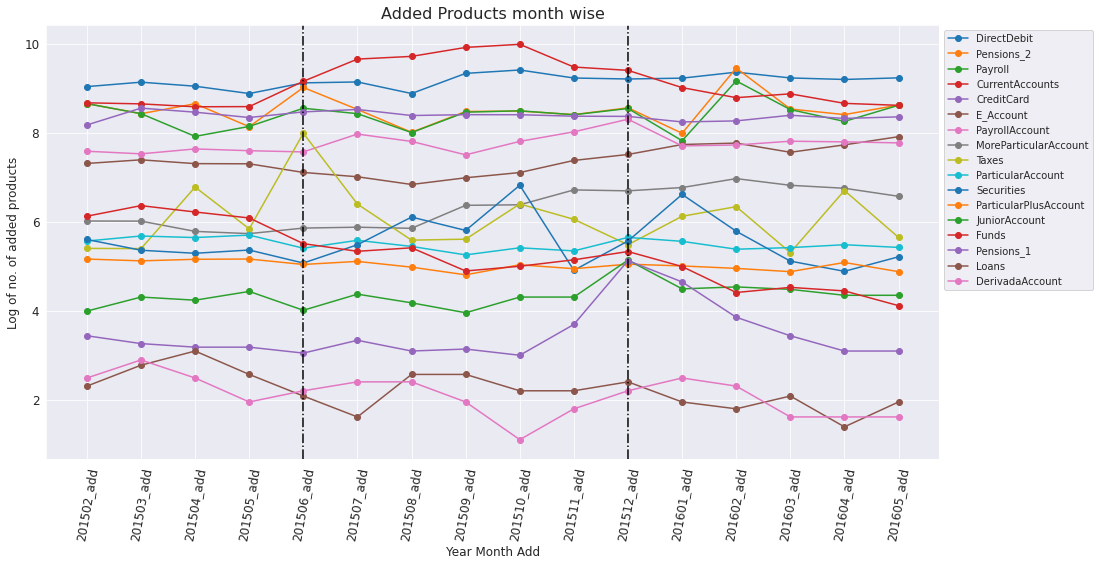

In [46]:
plt.figure(figsize=(16,8))
sns.set_style("darkgrid")
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[0]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[0]].values), marker="o", label=prodAdd_snapshot.index[0])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[1]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[1]].values), marker="o", label=prodAdd_snapshot.index[1])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[2]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[2]].values), marker="o",label=prodAdd_snapshot.index[2])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[3]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[3]].values), marker="o",label=prodAdd_snapshot.index[3])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[4]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[4]].values), marker="o",label=prodAdd_snapshot.index[4])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[5]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[5]].values), marker="o",label=prodAdd_snapshot.index[5])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[6]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[6]].values), marker="o",label=prodAdd_snapshot.index[6])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[7]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[7]].values), marker="o",label=prodAdd_snapshot.index[7])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[8]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[8]].values), marker="o",label=prodAdd_snapshot.index[8])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[9]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[9]].values), marker="o",label=prodAdd_snapshot.index[9])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[10]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[10]].values), marker="o",label=prodAdd_snapshot.index[10])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[11]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[11]].values), marker="o",label=prodAdd_snapshot.index[11])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[12]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[12]].values), marker="o",label=prodAdd_snapshot.index[12])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[13]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[13]].values), marker="o",label=prodAdd_snapshot.index[13])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[14]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[14]].values), marker="o",label=prodAdd_snapshot.index[14])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[15]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[15]].values), marker="o",label=prodAdd_snapshot.index[15])
plt.plot(prodAdd_snapshot.loc[prodAdd_snapshot.index[16]].index, np.log(prodAdd_snapshot.loc[prodAdd_snapshot.index[16]].values), marker="o",label=prodAdd_snapshot.index[16])
plt.axvline(x='201506_add',color='k', linestyle='dashdot')
plt.axvline(x='201512_add',color='k', linestyle='dashdot')
plt.title("Added Products month wise".format(i), fontsize=16)
plt.xlabel("Year Month Add",fontsize=12)
plt.ylabel("Log of no. of added products",fontsize=12)
plt.xticks(rotation=80,fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

###<h4><b> 11.1.1 Finalizing on New Features </b></h4>

* In the above graph if we see, the plots expands in middle and then shrinks back. 
* Product adding behaviour changes from June'15 onwards till Dec'15 and then from Jan'16 till May'16. I am anticipating same kind of behaviour untill June'16. 
* Hence, it makes sense that if we are recommending product for :    
 * <b>lets say June'15 we have to consider purchase behaviour of last 5 months i.e. from Jan-15 to May-15</b>
 * <b>Similiarly, for recommending product for June'16 we have to consider purchase behaviour of last 5 months i.e. from Jan-16 to May-16 </b>

###<h4><b> 11.1.2 Features on Test Data </b></h4>

1. We have to recommend products to the 9,29,615 customers given in the test Data for June'16. 
2. Now, along with the existing features of customer information, we will create new features which will tell us purchase history of the last 5 months (Jan'16-May-16) of each customer for each of the products.
3. So in total we will have :       
 * 17 features related to customer information (excluding Date and CustomerID)
 * 18 products to recommend from and 5 lags for each product, hence 18 * 5 = 90 new features
 * Total = 17+90 = 107 features

###<h4><b> 11.1.3 Features on Training Data </b></h4>

1. As we have seen earlier in EDA and as well as here in Product Adding behaviour of the customers that the training on whole past 17 months of data to recommend products for June'16 will result in irrelevant recommendations. This is due to periodicity of 6 months.
2. <b>Hence, I have decided my training and cv data to be June'15 with same 107 features.</b>

##<h3><b> 11.2 Create New Lag Features </b></h3>

#### Extract customers that had train data in May 2015 and June 15

In [ ]:
May15Custs  = train_vec[train_vec.Date=='2015-05-28']['CustomerID'].unique().tolist()
June15Custs = train_vec[train_vec.Date=='2015-06-28']['CustomerID'].unique().tolist()